In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import matplotlib
matplotlib.rcParams['figure.figsize'] = [18,4]
import matplotlib.style
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
pd.set_option("display.max_colwidth", None)

def launchDask():
    #TODO try, except
    gateway = Gateway()
    options = gateway.cluster_options()
    options.worker_memory=8
    clusters = gateway.list_clusters()
    clusters
    if len(clusters) >0:
        cluster = gateway.connect(clusters[0].name)
        print("using existing connection")#or shut down and start afresh cluster.shutdown(). otherwise I dunno how to apply custom options
        cluster.shutdown()
        cluster = gateway.new_cluster(options)
    else:
        cluster = gateway.new_cluster(options)
    return(cluster)
from dask_gateway import Gateway
from dask.distributed import Client
cluster = launchDask()
from distributed import Client
client = Client(cluster)
client
cluster.adapt(minimum=0, maximum=10)  

using existing connection


In [2]:
from distributed import Client
client = Client(cluster)
client

Client Scheduler: gateway://traefik-daskhub-dask-gateway.daskhub:80/daskhub.89b4b830105b4dc9b0956c23dbdf9bdd Dashboard: /services/dask-gateway/clusters/daskhub.89b4b830105b4dc9b0956c23dbdf9bdd/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


<h2>Prepare Input: Inventory lists and intake catalog pointers, read operations,etc.</h2>

In [3]:
z_inv_list = 'symlink.txt' 
#'s3://s3-inventory-collection/cmip6-pds/s3-inventory-config/hive/dt=2021-04-01-00-00/symlink.txt'
zsym = pd.read_csv(z_inv_list, delimiter='\n',dtype='unicode',index_col=False,header=None)
print(zsym)
zarr_inventory_pd = pd.concat(map(pd.read_parquet, (zsym[0].tolist()) ))
zarr_inventory_pd=zarr_inventory_pd[zarr_inventory_pd['size'].notna()] 

                                                                                                              0
0  s3://s3-inventory-collection/cmip6-pds/s3-inventory-config/data/b35822c4-bff7-4847-b83f-de0510b81596.parquet
1  s3://s3-inventory-collection/cmip6-pds/s3-inventory-config/data/918e936a-8365-4b42-877b-74e99f18a972.parquet


<h5> Quick checking of size as-is in the parquet after pre-processing </h5>

In [4]:
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count

print(len(zarr_inventory_pd)) 
zarr_inventory_pd=zarr_inventory_pd.set_index('key',drop=False)##3588469

zarr_inventory_dd = dd.from_pandas(zarr_inventory_pd,npartitions=40)


3588469


In [5]:
zarr_inventory_dd['vstore'] = zarr_inventory_dd.apply(
   lambda row: '/'.join([row['key'].split('/v20')[0],'v20'+row['key'].split('v20')[-1].split('/')[0]] ),axis =1).compute() 



/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/dataframe/core.py:4338: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [16]:
zarr_inventory_dd.reset_index(drop=False)

,vstore,size
0,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hurs/gr/v20200117,1626691143
1,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hursmax/gr/v20200117,2027105590
2,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hursmin/gr/v20200117,6030151646
3,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/mrro/gr/v20200117,1375531319
4,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/mrso/gr/v20200117,2833264354
...,...,...
30924,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/hfgeou/gn/v20200326,1850969
30925,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/masscello/gn/v20180802,11143778
30926,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/sftof/gn/v20180802,1705676
30927,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/thkcello/gn/v20180802,11129959


In [9]:
#ddize = df['size'].sum().compute()


In [13]:
df.head(0)

,size
vstore,


In [7]:
zarr_inventory_dd = ddize.to_frame()

In [17]:
zarr_inventory_dd = zarr_inventory_dd.groupby(['vstore'])['size'].sum()


In [20]:
zarr_inventory_dd = zarr_inventory_dd.to_frame()

In [31]:
zarr_inventory_dd = zarr_inventory_dd.reset_index(drop=False)

In [32]:
zarr_inventory_dd

,vstore,size
0,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hurs/gr/v20200117,1626691143
1,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hursmax/gr/v20200117,2027105590
2,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hursmin/gr/v20200117,6030151646
3,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/mrro/gr/v20200117,1375531319
4,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/mrso/gr/v20200117,2833264354
...,...,...
30924,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/hfgeou/gn/v20200326,1850969
30925,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/masscello/gn/v20180802,11143778
30926,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/sftof/gn/v20180802,1705676
30927,CMIP6/CMIP/IPSL/IPSL-CM6A-LR/piControl/r1i1p1f1/Ofx/thkcello/gn/v20180802,11129959


In [34]:
zarr_inventory_dd[zarr_inventory_dd['vstore'] == 'CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hurs/gr/v20200117']


,vstore,size
0,CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r8i1p1f2/day/hurs/gr/v20200117,1626691143


In [35]:
zarr_cat = 'https://cmip6-pds.s3.amazonaws.com/compare/pangeo-cmip6-noQC.csv.gz' 

dzarr = pd.read_csv(zarr_cat, dtype='unicode')
ddzarr = dd.from_pandas(dzarr, npartitions=40)
#ddzarr['vstore']=ddzarr.map_partitions(
#      lambda dzarr : dzarr.apply(
#          lambda row: lambda row: (row.zstore.split('s3://cmip6-pds/')[-1].split('v20')[0]+'v'+row.version), axis = 1)).compute() #scheduler='threads')

ddzarr['vstore'] = ddzarr.apply(lambda row: (row['zstore'].split('s3://cmip6-pds/')[-1].split('v20')[0]+'v'+row.version), axis = 1).compute()
##.split('/v20')[0],'v20'+row['key'].split('v20')[-1].split('/')[0]] ),axis =1).compute() 



/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/dataframe/core.py:4338: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'object'))

  warnings.warn(meta_warning(meta))


In [36]:
dzarrtmp = ddzarr.merge(zarr_inventory_dd, on='vstore', how='outer', suffixes=['', '_'], indicator=True)
dzarr = dzarrtmp[dzarrtmp._merge=='both']
# dzarr[dzarr['size'].notna()] 
#group by vstore and other facets, take sum of size


In [37]:
len(dzarr)

30236

In [38]:
ddzarr_groupby =dzarr.groupby(['zstore','vstore','version','source_id','table_id','institution_id','variable_id','member_id','grid_label','experiment_id'])#.sum('size').compute()
series_ddzarr = ddzarr_groupby['size'].sum().compute()


In [39]:
dzarr = series_ddzarr.to_frame()

In [40]:
dzarr = dzarr.sort_values(by=['version'])


In [41]:
dzarr

,,,,,,,,,,size
zstore,vstore,version,source_id,table_id,institution_id,variable_id,member_id,grid_label,experiment_id,
s3://cmip6-pds/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/evspsbl/gr/v20180608/,CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/evspsbl/gr/v20180608,20180608,E3SM-1-0,Amon,E3SM-Project,evspsbl,r1i1p1f1,gr,piControl,1.239387e+09
s3://cmip6-pds/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Lmon/mrros/gr/v20180608/,CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Lmon/mrros/gr/v20180608,20180608,E3SM-1-0,Lmon,E3SM-Project,mrros,r1i1p1f1,gr,piControl,3.020718e+08
s3://cmip6-pds/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/rsds/gr/v20180608/,CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/rsds/gr/v20180608,20180608,E3SM-1-0,Amon,E3SM-Project,rsds,r1i1p1f1,gr,piControl,1.103969e+09
s3://cmip6-pds/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Lmon/mrro/gr/v20180608/,CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Lmon/mrro/gr/v20180608,20180608,E3SM-1-0,Lmon,E3SM-Project,mrro,r1i1p1f1,gr,piControl,3.753891e+08
s3://cmip6-pds/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/prsn/gr/v20180608/,CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/prsn/gr/v20180608,20180608,E3SM-1-0,Amon,E3SM-Project,prsn,r1i1p1f1,gr,piControl,6.765843e+08
...,...,...,...,...,...,...,...,...,...,...
s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r21i1p1f1/Amon/clivi/gr/v20210223/,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r21i1p1f1/Amon/clivi/gr/v20210223,20210223,EC-Earth3,Amon,EC-Earth-Consortium,clivi,r21i1p1f1,gr,historical,8.258163e+08
s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r21i1p1f1/Omon/tos/gn/v20210223/,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r21i1p1f1/Omon/tos/gn/v20210223,20210223,EC-Earth3,Omon,EC-Earth-Consortium,tos,r21i1p1f1,gn,historical,4.383706e+08
s3://cmip6-pds/CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r21i1p1f1/Amon/tos/gr/v20210223/,CMIP6/CMIP/EC-Earth-Consortium/EC-Earth3/historical/r21i1p1f1/Amon/tos/gr/v20210223,20210223,EC-Earth3,Amon,EC-Earth-Consortium,tos,r21i1p1f1,gr,historical,4.287274e+08


In [42]:
type(dzarr)

pandas.core.frame.DataFrame

In [43]:
dzarr.head(1)


,,,,,,,,,,size
zstore,vstore,version,source_id,table_id,institution_id,variable_id,member_id,grid_label,experiment_id,
s3://cmip6-pds/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/evspsbl/gr/v20180608/,CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/evspsbl/gr/v20180608,20180608,E3SM-1-0,Amon,E3SM-Project,evspsbl,r1i1p1f1,gr,piControl,1.239387e+09


In [44]:
#esgf-world catalog
netcdf_cat = 'https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.csv.gz'
dnc = pd.read_csv(netcdf_cat, dtype='unicode')
dnc['key'] = dnc.apply(lambda row: row.path.split('s3://esgf-world/')[-1], axis = 1) #Add key or reuse path as needed--since parquet has the key, for merging later on
#merge dnc and nc_inventory_pd to incorporate size and then remove version duplicates

n_inv_list = 's3://s3-inventory-dest/esgf-world/cmip6-inventory/hive/dt=2021-03-30-00-00/symlink.txt'
nsym = pd.read_csv(n_inv_list, delimiter='\n',dtype='unicode',header=None)
nc_inventory_pd = pd.concat(map(pd.read_parquet, (nsym[0].tolist()) ))
if('is_delete_marker' in nc_inventory_pd): nc_inventory_pd=nc_inventory_pd[nc_inventory_pd['is_delete_marker']==False]    
if('is_latest' in nc_inventory_pd): nc_inventory_pd=nc_inventory_pd[nc_inventory_pd['is_latest']==True]
nc_inventory_pd = nc_inventory_pd[nc_inventory_pd['size'].notna()] 

dnctmp = dnc.merge(nc_inventory_pd, on='key', how='outer', suffixes=['', '_'], indicator=True)
dnetcdf = dnctmp[dnctmp._merge=='both']
dnetcdf = dnetcdf[dnetcdf['size'].notna()] 
dnetcdf = dnetcdf.drop(['frequency', 'modeling_realm'], axis=1) #since its NA in esgf-world csv
dnetcdf['zstore'] = dnetcdf.apply(lambda row: row.key.split('s3://esgf-world/')[-1].split('v20')[0], axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: row.zstore + str(row.version)+'/', axis = 1)


#298 in inv, not in intake
#221384 in intake only

<h5>merge dnetcdf and nc_inventory_pd to incorporate size and then remove version duplicates</h5>


<h4>TO BE EXPLAINED -- S3 inventory parquet versus intake_esm catalog discrepancies </h4>

In [ ]:
print(len(dnctmp[dnctmp._merge=='right_only']))
dnctmp_s3only = dnctmp[dnctmp._merge=='right_only']
#about 298 not in intake catalog- this could be because of elimination of problem files.
#TODO see one example, why did it not make it to intake
print('_nc_0 files',len(dnctmp_s3only[dnctmp_s3only['key'].str.endswith(".nc_0")]))
print('.jnl files',len(dnctmp_s3only[dnctmp_s3only['key'].str.endswith(".jnl")]))
dnctmp_s3key = dnctmp_s3only['key']
dnctmp_s3key.to_csv("delete_from_s3_extraneous.csv", encoding='utf-8', index=False)

In [ ]:
print(len(dnctmp[dnctmp._merge=='left_only']))
print(dnctmp['path'].iloc[1])
print(dnctmp['path'].iloc[0])
#dnctmp[dnctmp._merge=='left_only']['key'] #example



<h4>Optional QA</h4>


In [ ]:
#check for zero byte files
#QA 
nc_zero = nc_inventory_pd[nc_inventory_pd['size']==0]
print(len(nc_zero))
#for i in range(len(nc_zero)):
#    print(nc_zero['key'].iloc[i])

In [ ]:
#optional QA
searchval = "CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/CFmon/ta/gn/v20200318/ta_CFmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc"
#searchval = 'CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/v20200318/ps_AERmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc'

nc_inventory_pd.loc[nc_inventory_pd['key'] == searchval]
dnetcdf.loc[dnetcdf['key'] == searchval]


In [ ]:
#QA-crosscheck if needed

#searchval = 'CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/'
#d= dnetcdf.loc[dnetcdf['zstore']== searchval] 
#dd= d.loc[d['version']== 'v20180701']
#print(dd['size'].sum())#264,327,907


In [ ]:
#get aggregate size for each "dataset" , group by unique facets OR JUST zstore, but we need the other columns.
#TODO add model

dnetcdf=dnetcdf.groupby(['zstore','model','version','mip_table','institute','variable','ensemble_member','grid_label','experiment_id'], as_index=False).sum('size') #sum()['size'].sum()
dnetcdf = dnetcdf.sort_values(by=['version'])
dnetcdf = dnetcdf.drop_duplicates(subset=["zstore"],keep='last')


#.reset_index()



In [104]:
dnetcdf

,project,institute,model,experiment_id,mip_table,ensemble_member,grid_label,variable,temporal subset,version,...,key,bucket,version_id,is_latest,is_delete_marker,size,last_modified_date,_merge,zstore,vstore
0,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,AERmon,r1i1p1f1,gn,ps,185001-201412,v20200318,...,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/v20200318/ps_AERmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc,esgf-world,vpPZ4KQIxbMTqm9Iateo4WHGvg_JSNvc,True,False,2.431890e+08,2020-11-04 21:06:45+00:00,both,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/AERmon/ps/gn/v20200318/
1,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,CFmon,r1i1p1f1,gn,ta,185001-201412,v20200318,...,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/CFmon/ta/gn/v20200318/ta_CFmon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185001-201412.nc,esgf-world,sbrZOpHYp5Um9D3H6JTFAAY2oBOu8shZ,True,False,7.124593e+09,2020-11-04 21:06:44+00:00,both,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/CFmon/ta/gn/,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/CFmon/ta/gn/v20200318/
2,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,LImon,r1i1p1f1,gn,snc,185002-201412,v20200318,...,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snc/gn/v20200318/snc_LImon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185002-201412.nc,esgf-world,x0cuSOmBnkfohYY55mxj4Ls.4Rc3TN0x,True,False,4.516306e+07,2021-01-01 17:11:36+00:00,both,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snc/gn/,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snc/gn/v20200318/
3,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,LImon,r1i1p1f1,gn,snd,185002-201412,v20200318,...,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snd/gn/v20200318/snd_LImon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185002-201412.nc,esgf-world,kS2Byv2uYD03byjk6oBDlVT24as5BG54,True,False,9.064543e+07,2021-01-01 17:03:32+00:00,both,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snd/gn/,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snd/gn/v20200318/
4,CMIP6,AS-RCEC,TaiESM1,histSST-piNTCF,LImon,r1i1p1f1,gn,snw,185002-201412,v20200318,...,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snw/gn/v20200318/snw_LImon_TaiESM1_histSST-piNTCF_r1i1p1f1_gn_185002-201412.nc,esgf-world,YdMWtM7Jqo3QU6x7X6kop54tooiYFoYy,True,False,6.286604e+07,2021-02-23 13:43:36+00:00,both,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snw/gn/,CMIP6/AerChemMIP/AS-RCEC/TaiESM1/histSST-piNTCF/r1i1p1f1/LImon/snw/gn/v20200318/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949445,CMIP6,UA,MCM-UA-1-0,ssp585,Amon,r1i1p1f2,gn,rlut,201501-210012,v20190731,...,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/rlut/gn/v20190731/rlut_Amon_MCM-UA-1-0_ssp585_r1i1p1f2_gn_201501-210012.nc,esgf-world,nNwy8kcJp1v_2bmFBKAmg_YAlS01YWyT,True,False,3.179862e+07,2020-12-08 12:11:07+00:00,both,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/rlut/gn/,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/rlut/gn/v20190731/
949446,CMIP6,UA,MCM-UA-1-0,ssp585,Amon,r1i1p1f2,gn,rtmt,201501-210012,v20190731,...,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/rtmt/gn/v20190731/rtmt_Amon_MCM-UA-1-0_ssp585_r1i1p1f2_gn_201501-210012.nc,esgf-world,9Ggy9MAnJJlJ2XcbCcDkf8ayEZkBi6IJ,True,False,3.179865e+07,2020-12-04 18:33:01+00:00,both,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/rtmt/gn/,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Amon/rtmt/gn/v20190731/
949447,CMIP6,UA,MCM-UA-1-0,ssp585,Omon,r1i1p1f2,gn,sos,201501-210012,v20190731,...,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Omon/sos/gn/v20190731/sos_Omon_MCM-UA-1-0_ssp585_r1i1p1f2_gn_201501-210012.nc,esgf-world,2wIAnPDJaC5Lot4iO1iGdGz6WlJr2_Ju,True,False,6.344255e+07,2021-01-02 17:54:21+00:00,both,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1i1p1f2/Omon/sos/gn/,CMIP6/ScenarioMIP/UA/MCM-UA-1-0/ssp585/r1

In [105]:
#VERIFY
searchval = 'CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/'
dnetcdf.loc[(dnetcdf['version']=='v20180701') & (dnetcdf['institute']=='NOAA-GFDL') & (dnetcdf['experiment_id']=='historical') 
                                                                          & (dnetcdf['mip_table'] == 'Amon')
                                                                          & (dnetcdf['variable'] == 'rlus')]
                                                                    
#size shows aggregate size as desired 
#old version should not be displayed 'v20180701'



,project,institute,model,experiment_id,mip_table,ensemble_member,grid_label,variable,temporal subset,version,...,key,bucket,version_id,is_latest,is_delete_marker,size,last_modified_date,_merge,zstore,vstore
460406,CMIP6,NOAA-GFDL,GFDL-CM4,historical,Amon,r1i1p1f1,gr1,rlus,185001-194912,v20180701,...,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/rlus_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_185001-194912.nc,esgf-world,3ue4O38qB_hb4fcfM_lz4da3Jq1gJxnh,True,False,160201595.0,2020-11-15 20:31:33+00:00,both,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/
460407,CMIP6,NOAA-GFDL,GFDL-CM4,historical,Amon,r1i1p1f1,gr1,rlus,195001-201412,v20180701,...,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/rlus_Amon_GFDL-CM4_historical_r1i1p1f1_gr1_195001-201412.nc,esgf-world,LTLMpWkP8jP5zc7Y02SkFrx8zx4IVG1_,True,False,104126312.0,2020-11-15 20:31:37+00:00,both,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/,CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Amon/rlus/gr1/v20180701/


<h4>Compare buckets <h4>


<h5>Data volumes of cmip6-pds and esgf-world as a whole, considering latest DRS versions<h5>

In [45]:
#TODO for zarr
dzarr = dzarr.reset_index()

set_L = set(dzarr.zstore.unique())
set_G = set(dnetcdf.zstore.unique())

print('AWS-zarr (number of datasets): ',len(set_L),' AWS-netcdf (number of datasets):', len(set_G),' both (number of datasets):', len(set_G.union(set_L)))


AWS-zarr (number of datasets):  30236  AWS-netcdf (number of datasets): 241747  both (number of datasets): 271983


In [46]:
def bytesto(bytes, to, bsize=10):
    a = {'k' : 3, 'm': 6, 'g' : 9, 't' : 12}
    return(bytes / pow(bsize, a[to]))
#Usage: bytesto(size_in_bytes,'g')

In [47]:
#LATEST DRS VERSIONS 
print("AWS-netcdf in TB",bytesto(dnetcdf['size'].sum(),'t')) #
print("AWS-zarr in TB",bytesto(dzarr['size'].sum(),'t')) #

#DETERMINE what's common TODO 


AWS-netcdf in TB 663.574352169204
AWS-zarr in TB 128.666142413444


In [ ]:
print("So many filtered from removing old versions:", (total_from_parquet-bytesto(dnetcdf['size'].sum(),'t'))) 

<h4> Visual Comparison </h4>

In [48]:
dnetcdf['activity_id'] = dnetcdf.apply(lambda row: row.zstore.split('s3://esgf-world/CMIP6')[-1].split('/')[1], axis = 1)


In [49]:
#dnetcdf['vstore'] = dnetcdf.apply(lambda row: '/'.join((row.path.split('s3://esgf-world/CMIP6')[-1].split('/')[0:-1])), axis = 1)
dnetcdf['vstore'] = dnetcdf.apply(lambda row: '/'.join((row.zstore,row.version)), axis = 1)


In [50]:
dnetcdf = dnetcdf.rename(columns={"mip_table": "table_id","institute":"institution_id","variable":"variable_id"})

In [51]:
dzarr['activity_id'] = dzarr.apply(lambda row: row.zstore.split('s3://cmip6-pds/CMIP6')[-1].split('/')[1], axis = 1)


In [55]:
dcpp_nc = len(dnetcdf[dnetcdf.activity_id == 'DCPP'])
dcpp_zarr = len(dzarr[dzarr.activity_id == 'DCPP'])

We are not accounting for DCPP at this time since the definition of a dataset is yet to be determined here. 

In [52]:
dZR = dzarr[dzarr.activity_id != 'DCPP']
dNC = dnetcdf[dnetcdf.activity_id != 'DCPP']

In [56]:
m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['', '_'], indicator=False)
dnot_NC = m[m._merge=='left_only']

m = dZR.merge(dNC, on='zstore', how='outer', suffixes=['_', ''], indicator=False)
dnot_ZR = m[m._merge=='right_only']

dZRnNC = dnot_NC[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore','version', 
       'vstore','size']]

dNCnZR = dnot_ZR[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore','version', 
       'vstore','size']]


'''
dZRnNC = dnot_NC[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore','size']]

dNCnZR = dnot_ZR[['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version', 'status', 'severity', 'issue_url',
       'vstore','size']]

'''
'''
print('For all activities other than DCPP:')
print('AWS-zarr:  ', len(dZR),'datasets')
print('AWS-netcdf:', len(dNC),'datasets')
print('zarrs with no matching netcdfs:',len(dZRnNC),'datasets')
print('netcdfs with no matching zarrs: ',len(dNCnZR),'datasets')
'''
aws_zarr= len(dZR)
aws_nc = len(dNC)
zarr_MissingNC = len(dZRnNC)
nc_MissingZarr = len(dNCnZR)
in_both = aws_zarr - zarr_MissingNC
num_all = aws_zarr+aws_nc-in_both

print('DCPP (netcdf) datasets attribute to', dcpp_nc)
print('DCPP (zarr) datasets attribute to', dcpp_zarr)
print('For all activities other than DCPP, total unique datasets from both:', num_all )
print('S3/zarr has:  ',aws_zarr)
print('S3/netcdf has:',aws_nc)
print('S3/zarr needs:  ',nc_MissingZarr) #guestimate 402TB
print('S3/netcdf needs:', zarr_MissingNC )#guestimate 540TB
print('\n What is common in both buckets:',int(100*(in_both)/num_all),'%') #225TB



DCPP (netcdf) datasets attribute to 75452
DCPP (zarr) datasets attribute to 0
For all activities other than DCPP, total unique datasets from both: 873977
S3/zarr has:   30236
S3/netcdf has: 873977
S3/zarr needs:   0
S3/netcdf needs: 0

 What is common in both buckets: 3 %


In [58]:
dZR_size= dZR['size'].sum()
dNC_size = dNC['size'].sum()
dNCnZR_size = dNCnZR['size'].sum()
dZRnNC_size = dZRnNC['size'].sum()

in_both_size = dZR_size - dNC_size
num_all_size = dZR_size+dNC_size -in_both

#df_dict_size = {'ZARR':dZR_size,'NetCDF':dNC_size,'ZARR but not NetCDF':dZRnNC_size,'NetCDF but not ZARR':dNCnZR_size}


print('For all activities other than DCPP, size of total unique datasets from both:', num_all_size )
print('S3/zarr has:  ',bytesto(dZR_size,'t'))
print('S3/netcdf has:',bytesto(dNC_size ,'t'))
print('S3/zarr needs:  ',bytesto(dNCnZR_size,'t'),'TB') #guestimate 402TB
print('S3/netcdf needs:', bytesto(dZRnNC_size,'t'),'TB')#guestimate 540TB
both_size = bytesto(int(100*(in_both_size)/num_all_size),'t')
print('\n What is common in both buckets:',in_both_size,'T',both_size,'%') #225TB

#NOTE: zarr size is not included yet, says 0, but its NA for now

For all activities other than DCPP, size of total unique datasets from both: 775501687279094.0
S3/zarr has:   128.666142413444
S3/netcdf has: 646.835544895886
S3/zarr needs:   0.0 TB
S3/netcdf needs: 0.0 TB

 What is common in both buckets: -518169402482442.0 T -6.6e-11 %


In [59]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=10)

In [60]:
def plot_facet(df_dict,facet='table_id',top_n=8,ymax=300000,ylabel='number',title_add='',units='t'):   
    labels = df_dict.keys()
    stables = set()
    for label in labels:
        stables = stables.union(set(df_dict[label][facet].unique()))    
    tables = sorted(list(stables))
    
    vdfs = {}
    for label in labels:
        df = df_dict[label]
        nvdf = []
        for table in tables:
            if("volume" in ylabel):
                ndf = df[df[facet]==table]['size'].sum()
                ndf = round(bytesto(ndf,units))
            else:
                ndf = df[df[facet]==table].vstore.nunique()
            nvdf += [ndf]
        vdfs[label] = nvdf
    
    names = []
    totals = []
    for item,table in enumerate(tables):
        names += [table]
        tsum = 0
        for label in labels:
            tsum += vdfs[label][item]
        totals += [tsum]

    num_dict = {'name': names,'total':totals}
    for label in labels:
        num_dict[label] = vdfs[label]
    
    df_nums = pd.DataFrame(num_dict)  
    
    df_nums = df_nums.sort_values(by=['total'],ascending=False)
    #df_nums = df_nums.sort_values(by=[list(labels)[1]],ascending=False)

    width = 1.0/(1+len(labels))  # the width of the bars
    
    fig, ax = plt.subplots()

    names = df_nums.name.values[:top_n]
    x = np.arange(len(names)) 
    
    for item,label in enumerate(labels):
        vdf = df_nums[label].values[:top_n]
        rects = ax.bar(x - (len(labels)/2-item-0.5)*width, vdf, width, label=label)
        autolabel(ax,rects)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} top {top_n} by {facet}'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    #plt.savefig(f'compare-{facet}.png')

    plt.show()

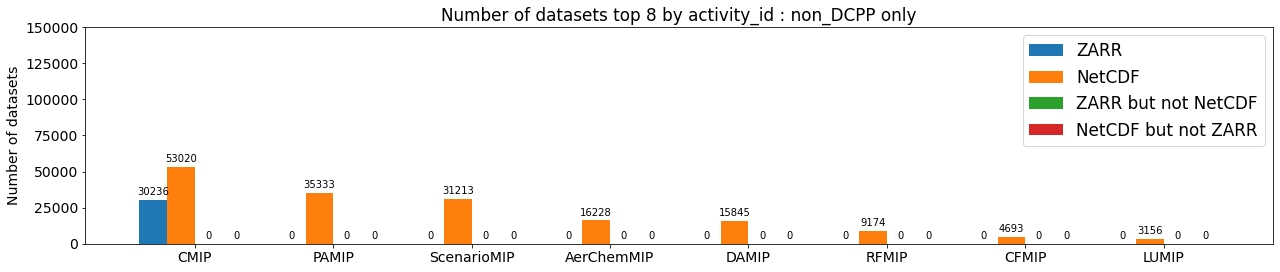

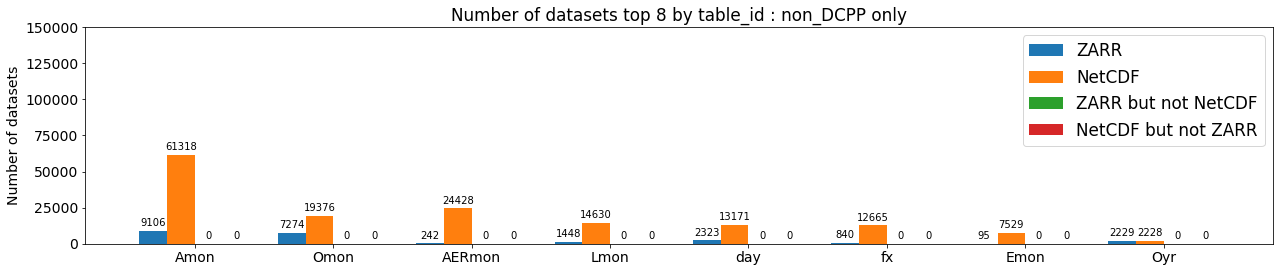

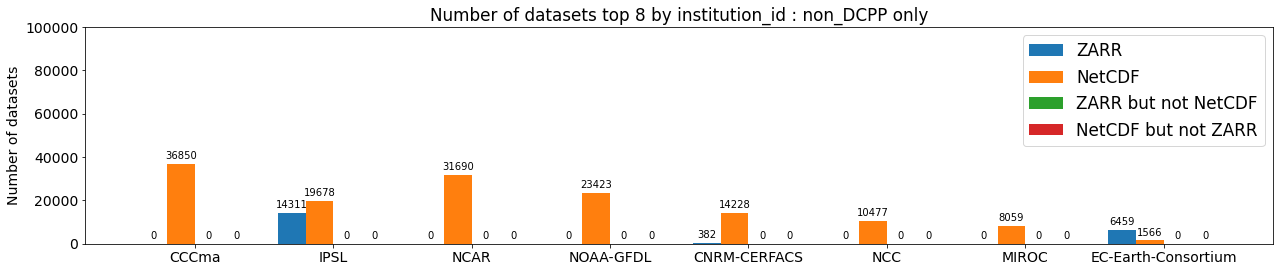

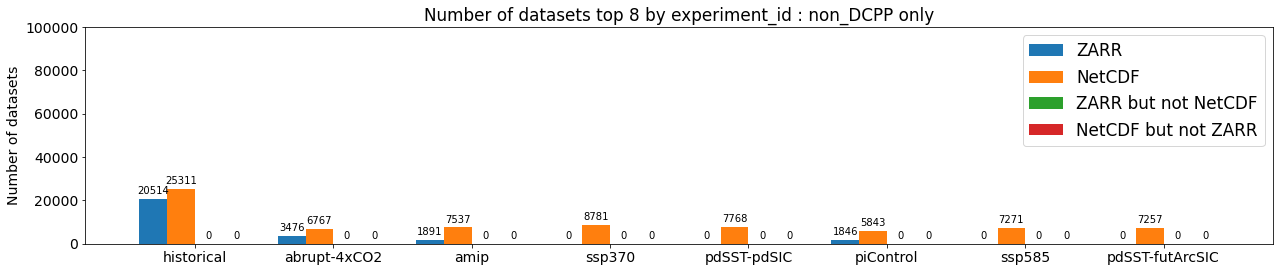

In [61]:
df_dict = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}
plot_facet(df_dict,facet='activity_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='table_id',ymax=150000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='institution_id',top_n=8,ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')
plot_facet(df_dict,facet='experiment_id',ymax=100000,ylabel='Number of datasets',title_add = ' : non_DCPP only')


In [62]:
dZR.head(0)

,zstore,vstore,version,source_id,table_id,institution_id,variable_id,member_id,grid_label,experiment_id,size,activity_id


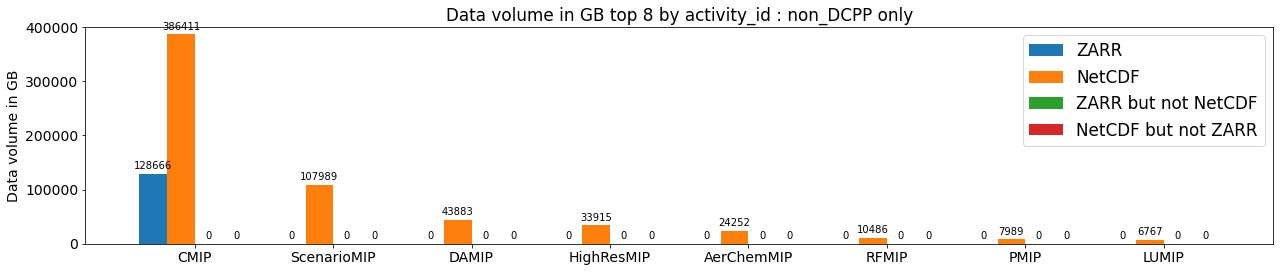

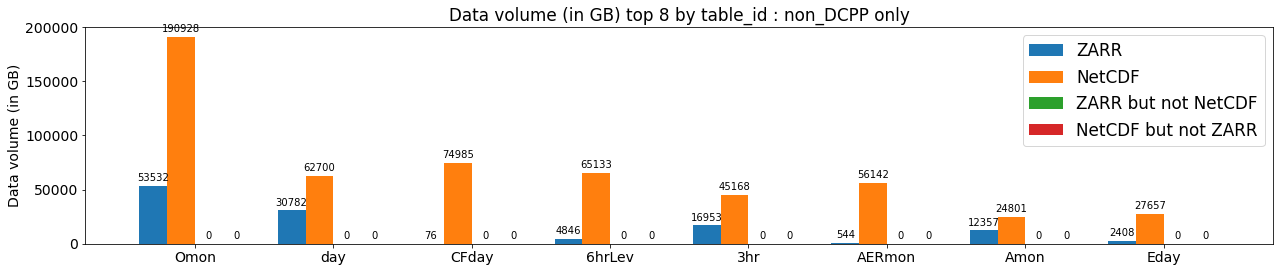

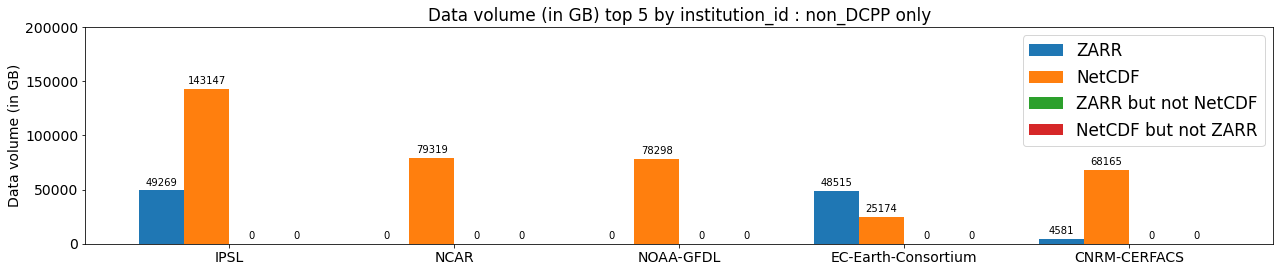

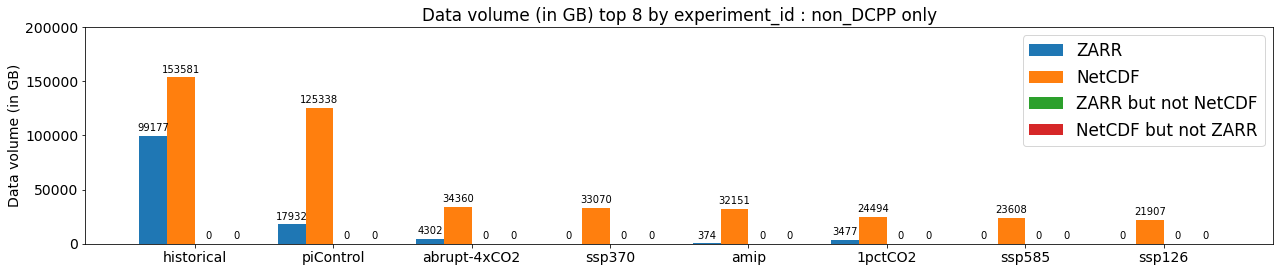

In [63]:
df_dict_size = {'ZARR':dZR,'NetCDF':dNC,'ZARR but not NetCDF':dZRnNC,'NetCDF but not ZARR':dNCnZR}

plot_facet(df_dict_size,facet='activity_id',ymax=400000, ylabel='Data volume in GB',title_add = ' : non_DCPP only',units='g')
plot_facet(df_dict_size,facet='table_id',ymax=200000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only',units='g')
plot_facet(df_dict_size,facet='institution_id',top_n=5,ymax=200000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only',units='g')
plot_facet(df_dict_size,facet='experiment_id',ymax=200000,ylabel="Data volume (in GB)",title_add = ' : non_DCPP only',units='g')


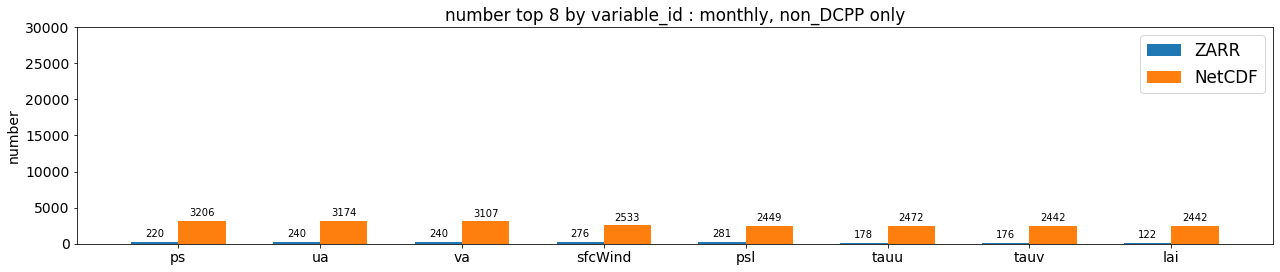

In [64]:
dZRm = dZR[dZR.table_id.str.contains('mon')]
dNCm = dNC[dNC.table_id.str.contains('mon')]
df_dict = {'ZARR':dZRm,'NetCDF':dNCm}
plot_facet(df_dict,facet='variable_id',ymax=30000,title_add = ' : monthly, non_DCPP only',units='g')